# Lab 1

* Create sinusoidal data with gaussian noise
* Create polynomial features (up to degree "max_degree")
* Fit a linear model with least square regression
* Introduce $l_2$ regularization
* Use cross-validation to determine best  regularization coefficient
* **Bonus :** Verify regularization coefficient scales linearly with dataset size

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Creation of the datasets

In [2]:
n_train = 1000
n_test = 50

In [3]:
def create_data(n_train, n_test, sigma=0.3):
    """
    Create 2 random datasets (train and test) from the same distribution.
    Both are 2D point clouds with a uniform sampling of the segment [0,2) for the x axis,
    the y axis being a "sinusoide + affine function + gaussian noise".
    
    Parameters:
        - n_train (int): size of the training set.
        - n_test (int): size of the test set.
        - sigma (float): std of the gaussian noise used.
    Returns:
        - data_train (tuple): the training data, tuple of arrays (x_train, y_train) of size n_train.
        - data_test (tuple): the test data, tuple of arrays (x_test, y_test) of size n_test.
    """
    # sample the 1st coordinate uniformaly
    x_train = np.random.uniform(low=0.0, high=2.0, size=n_train)
    x_train = np.sort(x_train)
    x_test = np.random.uniform(low=0.0, high=2.0, size=n_test)
    x_test = np.sort(x_test)
    # additive gaussian noise
    noise_train = sigma*np.random.randn(n_train)
    noise_test = sigma*np.random.randn(n_test)
    # sinusoide 2nd cooordinate
    y_train = np.sin(2*np.pi*x_train) + noise_train
    y_test = np.sin(2*np.pi*x_test) + noise_test
    # add affine function
    a , b = 2 , 1
    y_train = a*x_train + b + y_train
    y_test = a*x_test + b + y_test
    # concatenante the 2D data
    data_train = (x_train, y_train)
    data_test = (x_test, y_test)
    
    return data_train, data_test

### Q1: Plot the training set and testing set.

In [4]:

(x_train, y_train), (x_test, y_test) = create_data(n_train, n_test)

Text(0.5, 1.0, 'Testing Data')

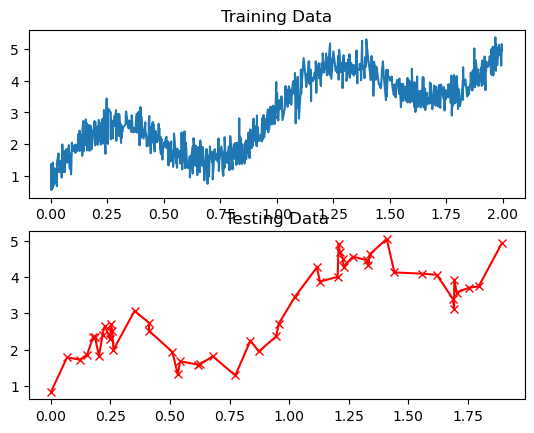

In [5]:
# Plotting the generated data

f = plt.figure()
ax0 = f.add_subplot(211)
ax1 = f.add_subplot(212)

ax0.plot(x_train, y_train, label='Training Set')
ax0.set_title("Training Data")

ax1.plot(x_test, y_test, label='Testing Set', marker='x', color='r')
ax1.set_title("Testing Data")

### Q2: Create Polynomial features

Create polynomial features of the type: $\phi_j(x)=x^j$ for $j=0,...,m$ .

In [6]:
max_degree = 10

In [7]:
def polynomial_features(x, max_degree):
    """
    Create an array of polynomial features $\phi_j(x)=x^j$ for j=0,...,max_degree.
    
    Parameters:
        - x (np.array): of size n.
        - max_degree (int): the maximum degree of the polynomial features.
    Returns:
        - features (np.array): of shape (n, max_degree + 1).
    """
    n = len(x)
    # Initialize an array to store the polynomial features
    features = np.zeros((n, max_degree + 1))
    # Populate the array with polynomial features
    for j in range(max_degree + 1):
        features[:, j] = x ** j       

    return features

In [8]:
X_train = polynomial_features(x_train, max_degree)
X_test = polynomial_features(x_test, max_degree)


### Q3: Compute the parameters of the linear regression for the least square objective

We want to find $w^* = \underset{w}{\operatorname{argmin}} \Vert y - Xw \Vert ^2 $

[Solution: $w^* = (X^T X)^{-1} X^T y$ ]

In [9]:
def compute_averaged_squared_error(X, y, w):
    """
    Given the matrix of features, the parameters of the linear regression and the vector of targets,
    returns the squared distance between the predictions and the ground truth.
    
    Parameters:
        - X (np.array): polynomial features, of shape (n, max_degree + 1).
        - y (np.array): target values, of shape (n,).
        - w (np.array): parameters of the linear regression, of shape (max_degree + 1,).
    Returns:
        - error (float): the averaged squared distance between the predictions and the ground truth.
    """
    
    y_hat = X @ w
    n = len(y_hat)
    error = np.linalg.norm(y - y_hat, 2)**2
      
    return error/n

In [10]:
def fit_least_square(X, y):
    """
    Compute the parameters of the linear regression using the polynomial features.
    
    Parameters:
        - X (np.array): polynomial features, of shape (n, max_degree + 1).
        - y (np.array): target values, of shape (n,).
    Returns:
        - w_star (np.array): parameters of the linear regression, of shape (max_degree + 1,).
        - y_hat (np.array): predictions of the linear model, of shape (n,).
    """
    
    w = X.T @ X
    w = np.linalg.pinv(w)   # It is not often inversible so we use the pseudo inverse
    w = w @ X.T
    w_star = w @ y
    
    y_hat = X @ w_star
    
    return w_star, y_hat

In [11]:
w, y_hat_train = fit_least_square(X_train, y_train)    #on calcul le w avec seulemnt le train
train_error = compute_averaged_squared_error(X_train, y_train, w)
test_error = compute_averaged_squared_error(X_test, y_test, w)    

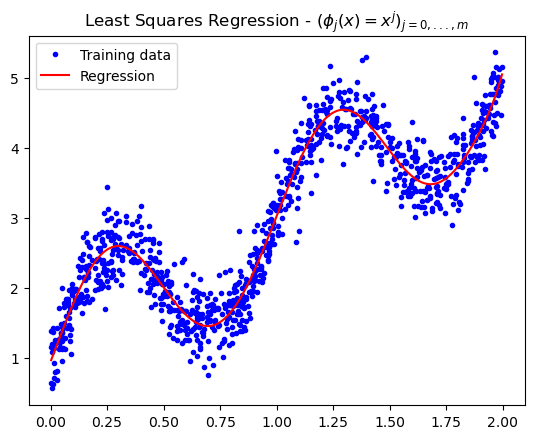

Train error:  0.0868
Test error:  0.0970


In [12]:
plt.plot(x_train, y_train, 'b.', label='Training data')
plt.plot(x_train, y_hat_train, 'r', label='Regression')
plt.title('Least Squares Regression - $(\phi_j(x) = x^j)_{j=0,...,m}$')
plt.legend()
plt.show()

print(f'Train error: {train_error: .4f}')
print(f'Test error: {test_error: .4f}')

In [13]:
print(w)

# 173 is a lot, we want to avoid that so we are adding a regularization

[   0.94449307    8.3597655     5.73973101  -67.38519442   30.90538781
  102.54730727  -51.44893142 -112.14964358  128.39724284  -49.65054479
    6.76446298]


### Q4: $l_2$ Regularization

We want to find $w^* = \underset{w}{\operatorname{argmin}} \Vert y - Xw \Vert ^2 + \mu \Vert w \Vert^2$

[Solution: $w^* = (X^T X + \mu I_d )^{-1} X^T y$ ]

In [14]:
def fit_regularized_least_square(X, y, mu):
    """
    Compute the parameters of the linear regression with l2 regularization using the polynomial features.
    
    Parameters:
        - X (np.array): polynomial features, of shape (n, max_degree + 1).
        - y (np.array): target values, of shape (n,).
        - mu (float): the l2 regularization parameter.
    Returns:
        - w (np.array): parameters of the regularized linear regression, of shape (max_degree + 1,).
        - y_hat (np.array): predictions of the regularized linear model, of shape (n,).
    """
    w = X.T @ X
    w = w + mu*np.eye(len(w))
    w = np.linalg.pinv(w)   # It is not often inversible so we use the pseudo inverse
    w = w @ X.T
    w_star = w @ y
    
    y_hat = X @ w_star
    
    return w_star, y_hat


In [15]:
w_reg, y_hat_train_reg = fit_regularized_least_square(X_train, y_train, mu=0.01)
train_error_reg = compute_averaged_squared_error(X_train, y_train, w_reg)
test_error_reg = compute_averaged_squared_error(X_test, y_test, w_reg)

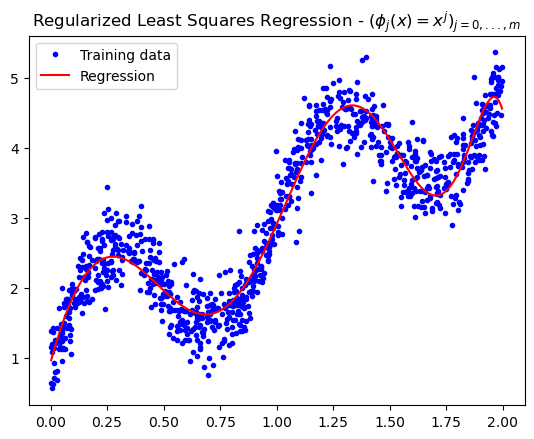

Train error:  0.1019
Test error:  0.1062


In [16]:
plt.plot(x_train, y_train, 'b.', label='Training data')
plt.plot(x_train, y_hat_train_reg, 'r', label='Regression')
plt.title('Regularized Least Squares Regression - $(\phi_j(x) = x^j)_{j=0,...,m}$')
plt.legend()
plt.show()

print(f'Train error: {train_error_reg: .4f}')
print(f'Test error: {test_error_reg: .4f}')

In [17]:
# Always Regularize before minimizing something

print(w_reg)

[  0.93528699  11.8412599  -25.04150155   2.03875134  16.55297119
   7.66484582  -7.14467212  -8.67739116   3.32563973   2.2965716
  -0.88437792]


### Q5:  $k$-fold cross-validation to choose best parameter $\mu$ 

In this part, we will use $k$-fold cross-validation to choose the best value of the parameter $\mu$.
For that, we will:
* create a function that returns a list of $n$ indices randomly attributed to $k$ different lists.
* create a function that iterate over those list of indices, take one to use for defining the validation set and use the other for training, fit a regularized linear model on the training set with a given value of $\mu$, evaluate it on the validation set, and returns the average performance over all the splits.
* create a function that returns the best value of $\mu$ of a given list.

In [18]:
# It helps to choose the good mu

In [19]:
def build_k_folds(n, k):
    """
    Randomly splits the indices {0,1,...,n-1} in k different arrays.
    
    Parameters:
        - n (int): size of the dataset to split.
        - k (int): number of folds.
    Returns:
        - list_of_folds (list of arrays): list of k np.array containing the indices.
    """
    ids_all = np.random.permutation(np.arange(n))
    size_folds = n//k
    list_of_folds = []
    for i in range(k-1):
        list_of_folds.append(ids_all[i*size_folds:(i+1)*size_folds])
  #for the last fold take all the remaining data 
  # so that no data is unused in case 
    list_of_folds.append(ids_all[(k-1)*size_folds:])
    return list_of_folds

In [20]:
k_folds = build_k_folds(n_train, k=10)
k_folds

[array([643, 221, 408, 235, 677, 329,  43, 943, 125, 674, 434, 536, 448,
        176, 761, 192, 570, 311, 781, 321, 798, 950, 631, 838, 202, 432,
        925, 604, 828, 245,  78, 816, 226,   3, 630, 431, 208, 921, 199,
         39, 465, 249, 450, 387, 913, 518, 293, 437, 164, 447,  59, 788,
        703, 297,  29, 905, 275, 710, 973, 648, 196, 750, 953, 445, 742,
        519, 657, 412, 158, 365, 153, 827, 983, 933, 367, 907, 522, 909,
        987, 223, 610, 353, 938, 150,  96, 616, 549, 930, 874, 844, 904,
        599, 491, 623, 881,  86, 108, 975,  68, 776]),
 array([103, 897, 400, 243, 820, 461, 956, 381, 757, 767, 923, 422, 388,
        470, 778, 718, 676, 228, 178,  45, 338, 723,  13,  17, 665, 444,
        383, 214, 637, 993, 481, 389, 740, 984,  92, 515,  90, 888, 316,
        159, 807, 972, 683, 692, 940, 300, 966,  36, 901, 334, 877,  52,
        856, 559, 641, 835, 262, 721, 716, 530, 960, 539, 653, 882, 292,
        976, 963, 271, 532,  81, 658, 285, 833, 451, 401, 486, 673, 5

In [21]:
def evaluate_mu_on_k_folds(k_folds, X, y, mu):
    """
    Iterate over the folds, take one set of indices to create the validation set,
    use the remaining ones for the train set, fit the regularized model on the training set,
    report the value of the error on the validation set, returns the average error value over the splits.
    
    Parameters:
        - k_folds (list of arrays): list of k np.array containing the indices.
        - X (np.array): polynomial features, of shape (n, max_degree + 1).
        - y (np.array): target values, of shape (n,).
        - mu (float): the l2 regularization parameter.
    Returns:
        - averaged_error (float): the average validation error over the k splits.
    """
    list_of_errors = []
    k = len(k_folds)
    for i in range(k):
        # create a copy of the list of the folds
        ids_all = k_folds.copy()
        # pop the ids of the validation set
        ids_val = ids_all.pop(i)
        # stitch together the ids of the training set
        ids_train = np.concatenate(ids_all)
        # gather the training and validation sets
        X_val, y_val = X[ids_val], y[ids_val]
        X_train, y_train = X[ids_train], y[ids_train]
        # run the regularized least square on the training set
        w_reg, y_hat_train_reg = fit_regularized_least_square(X_train, y_train, mu)
        # compute the error on the validation set
        val_error_reg = compute_averaged_squared_error(X_val, y_val, w_reg)
        list_of_errors.append(val_error_reg)
    return np.mean(list_of_errors)

In [22]:
evaluate_mu_on_k_folds(k_folds, X_train, y_train, mu=0.00001)

0.08831202337349657

In [23]:
def grid_search(k_folds, X, y, list_of_mu_to_test):
    """
    Given a list of parameter mu to test, returns the best performing one on the cross-validation procedure.
    
    Parameters:
        - k_folds (list of arrays): list of k np.array containing the indices.
        - X (np.array): polynomial features, of shape (n, max_degree + 1).
        - y (np.array): target values, of shape (n,).
        - list_of_mu_to_test (list of floats): list of mu to evaluate by cross-validation.
    Returns:
        - best_mu (float): the best performing value among the given list.
    """
    
    best_error = np.infty
    list_of_errors = []
    best_mu = None
    
    for mu in list_of_mu_to_test : 
        error = evaluate_mu_on_k_folds(k_folds,X,y,mu)
        list_of_errors.append(error)
        if error < best_error : 
            best_error = error
            best_mu = mu
    #(print list of error)
    return best_mu

In [24]:
list_of_mu_to_test = [1, 1e-1, 1e-2, 1e-3, 1e-4, 5e-5, 2.5e-5, 1e-5, 7.5e-6, 5e-6, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 0.0]

In [25]:
grid_search(k_folds, X_train, y_train, list_of_mu_to_test)

7.5e-06

### BONUS: scaling law of the parameter $\mu$: observe the dependency of $\mu$ in the number of samples.

In [26]:
def evolution_of_mu_with_n(list_of_n, list_of_mu_to_test, max_degree=10, k=5):
    """
    Test different values of n_train and returns the evolution of the parameter mu with the dataset's size.
    
    Parameters:
        - list_of_n (list of ints): the different dataset's size to test.
        - list_of_mu_to_test (list of floats): list of mu to evaluate by cross-validation.
        - max_degree (int): the maximum degree to consider for the polynomial features.
        - k (int): number of folds in the cross-validation.
    Returns:
        - list_of_mu (list of floats): the different best values of mu for each dataset's size.
    """
    
    # FILL HERE
    
    return list_of_mu

In [78]:
list_of_n = [20, 100, 200, 500, 700, 1000, 2000, 5000, 7000, 10000]
list_of_mu = evolution_of_mu_with_n(list_of_n, list_of_mu_to_test, max_degree=10, k=5)

NameError: name 'list_of_mu' is not defined

In [79]:
plt.plot(list_of_n, list_of_mu)
plt.yscale('log')
plt.title('Evolution of the best $\mu$ with $n$.')
plt.xlabel('$n$')
plt.ylabel('$\mu$')
plt.show()

NameError: name 'list_of_mu' is not defined